<a href="https://colab.research.google.com/github/NurikS/StockPriceAnalysis/blob/master/StockAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock analysis
#### This is the 2nd homework for the "make money with machine learning" course.

I have decided to analyze Microsoft stocks.

First let's import our data

In [1]:
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 1, 1)

df = web.DataReader("MSFT", "yahoo", start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.443624
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.451517
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,24.301458
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,24.048725
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,24.214581


In [2]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03,2264.000000
mean,48.480839,47.635742,48.070428,48.078754,4.163436e+07,44.056861
std,24.122417,23.658304,23.918008,23.896496,2.348979e+07,24.912756
min,23.320000,22.730000,23.090000,23.010000,7.425600e+06,18.340149
25%,29.190001,28.615001,28.887499,28.860001,2.586055e+07,23.907104
50%,41.674999,41.040001,41.369999,41.469999,3.620060e+07,37.109535
75%,58.067501,57.427499,57.872499,57.889999,5.172612e+07,54.531412
max,116.180000,114.930000,115.419998,115.610001,3.193179e+08,113.821434


In [3]:
df.shape

(2264, 6)

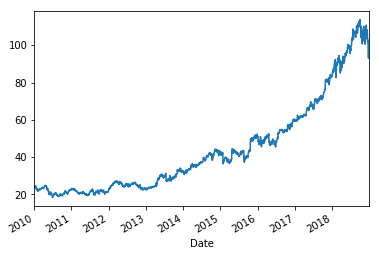

In [4]:
import matplotlib.pyplot as plt

close_px = df["Adj Close"]
close_px.plot(label='AAPL')

In [0]:
predictive_window = 29
num_samples = len(df) - predictive_window
indices = np.arange(num_samples).astype(np.int)[:, None] + np.arange(predictive_window + 1).astype(np.int)

data = df["Adj Close"].values[indices]

In [0]:
X = data[:, :-1]
y = data[:, -1]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

First let's try some linear model

In [12]:
from sklearn.linear_model import Ridge

RidgeClf = Ridge(alpha=0.1)
RidgeClf.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
preds = RidgeClf.predict(X_test)

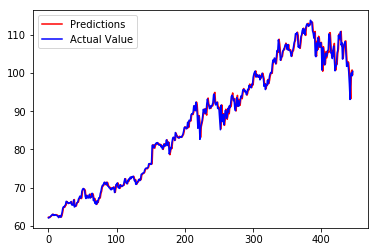

In [14]:
plt.plot(preds, 'r', label="Predictions")
plt.plot(y_test, 'b', label="Actual Value")
plt.legend()

This looks suspicious. Too good. Let's try tree-based models, such as gradient boosted trees.

In [50]:
from xgboost import XGBRegressor as Regressor

GBClf = Regressor()
GBClf.fit(X_train, y_train)

[20:41:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [51]:
X_test

array([[ 60.90365219,  60.84661102,  61.53113556, ...,  62.10502243,
         61.41635132,  62.20067596],
       [ 60.84661102,  61.53113556,  61.7606926 , ...,  61.41635132,
         62.20067596,  62.04763794],
       [ 61.53113556,  61.7606926 ,  61.72242355, ...,  62.20067596,
         62.04763794,  62.15285873],
       ...,
       [105.28556824, 103.79250336, 106.07659912, ...,  97.12810516,
         93.07409668,  99.43197632],
       [103.79250336, 106.07659912, 107.07525635, ...,  93.07409668,
         99.43197632, 100.04501343],
       [106.07659912, 107.07525635, 103.44643402, ...,  99.43197632,
        100.04501343,  99.26387787]])

In [0]:
predsGB = GBClf.predict(X_test)

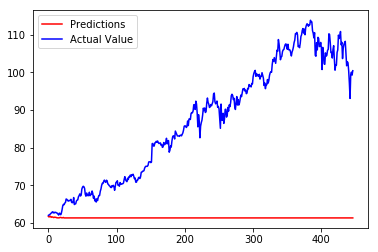

In [49]:
plt.plot(predsGB, 'r', label="Predictions")
plt.plot(y_test, 'b', label="Actual Value")
plt.legend()

It is understandable that tree based methods perform worse than linear ones. However, there might be something else, need to check.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.optimizers import Adam
from tensorflow.keras.losses import Huber


model=Sequential()
model.add(Conv1D(filters=128, kernel_size=5, input_shape=(predictive_window, 1), strides=1, padding="causal", activation="tanh"))
model.add(Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"))
model.add(LSTM(128, activation="tanh", return_sequences=True))
model.add(LSTM(128))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1))

model.compile(loss=Huber(), optimizer=Adam(lr=0.001), metrics=["mae"])



In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
transform = scaler.fit_transform(df["Adj Close"].values[:,None])
transform = transform[indices]
X2 = transform[:,:-1]
y2 = transform[:,-1]
X_train_reshaped, X_test_reshaped, y_train_reshaped, y_test_reshaped = train_test_split(X2, y2, test_size=0.2, shuffle=False)

In [0]:
model.fit(X_train_reshaped, y_train_reshaped, batch_size=128, epochs=150)

In [0]:
predsNN = scaler.inverse_transform(model.predict(X_test_reshaped, batch_size=128))

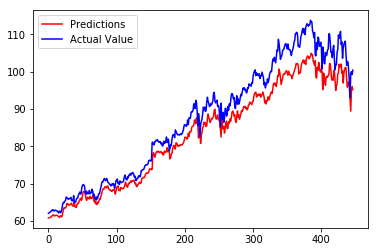

In [78]:
plt.plot(predsNN, 'r', label="Predictions")
plt.plot(y_test, 'b', label="Actual Value")
plt.legend()